# Ghouls, Goblins and Ghosts... Boo!

##  Соревнование https://www.kaggle.com/competitions/ghouls-goblins-and-ghosts-boo/overview

### Задача классификации. По данным о монстрах гулях, гоблинах и приведениях предсказать какой монстр перед нами.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import pickle

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer

from sklearn.datasets import load_digits
from sklearn.impute import SimpleImputer
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.compose import ColumnTransformer

## Анализ данных соревнования

По условиям соревнования предоставляются данные train.csv и test.csv

train.csv содержит данные о монстрах: 
- id - id монстра
- bone_length - средняя длина кости у существа, нормализованная между 0 и 1
- rotting_flesh - процент гниющей плоти в существе
- hair_length - средняя длина волос, нормализованная от 0 до 1
- has_soul - процент души в существе
- color - доминирующий цвет существа: 'white','black','clear','blue','green','blood'
- type - целевая переменная: 'Ghost', 'Goblin', and 'Ghoul

test.csv имеет аналогичную структуру кроме колонки type

In [25]:
boo_train = pd.read_csv('train.csv')
boo_train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [26]:
boo_test = pd.read_csv('test.csv')
boo_test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [27]:
boo_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             371 non-null    int64  
 1   bone_length    371 non-null    float64
 2   rotting_flesh  371 non-null    float64
 3   hair_length    371 non-null    float64
 4   has_soul       371 non-null    float64
 5   color          371 non-null    object 
 6   type           371 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [28]:
boo_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             529 non-null    int64  
 1   bone_length    529 non-null    float64
 2   rotting_flesh  529 non-null    float64
 3   hair_length    529 non-null    float64
 4   has_soul       529 non-null    float64
 5   color          529 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 24.9+ KB


Посмотрим данные подробней:

In [29]:
boo_train_sh = boo_train[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']]

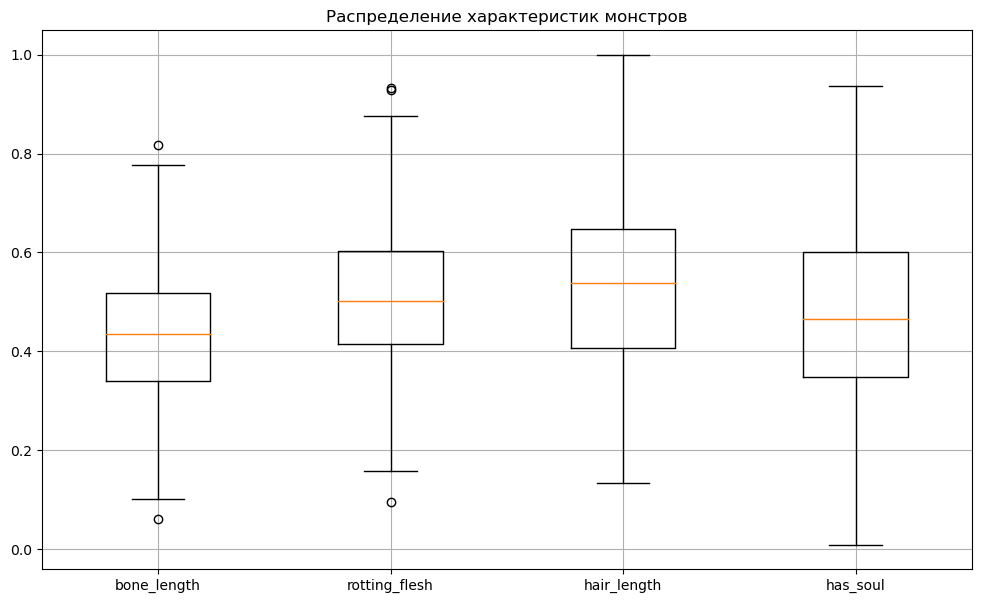

In [30]:
plt.figure(figsize=(12, 7))
plt.boxplot(boo_train_sh, labels=boo_train_sh.columns) 
plt.title("Распределения характеристик монстров")
plt.grid(True)
plt.show()

In [31]:
boo_train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


Числовые данные распределены достаточно равномерно, форма распределения похожая. Распределения не имеют резких выбросов. bone_length и hair_length смещены влево, has_soul смещено вправо. Медианы распределений находятся в промежутке 0.43 до 0.55.

bone_length и rotting_flesh имеют выбросы в данных и снизу и сверух. hair_length и has_soul не имеют выбросов.

C:\Users\malen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


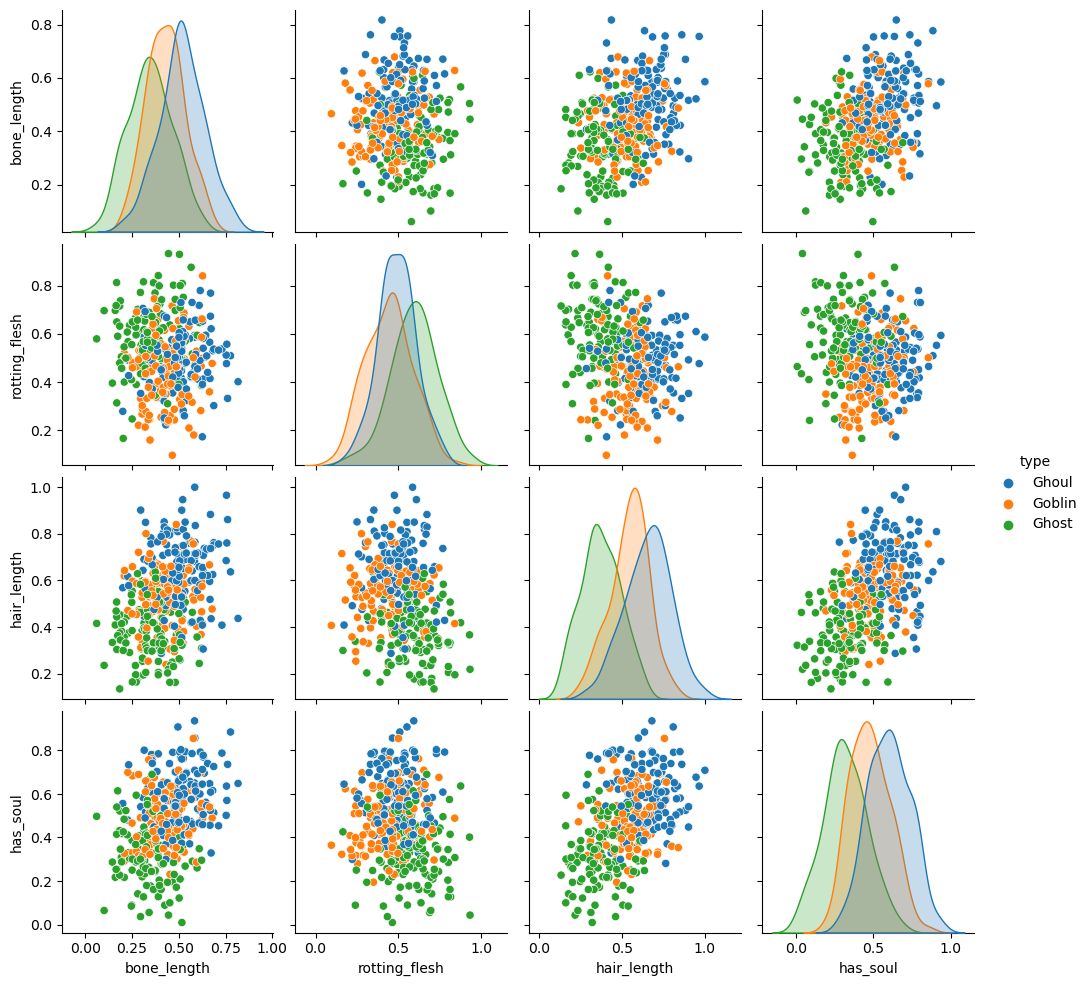

In [32]:
sns.pairplot(boo_train.drop('id',axis=1), hue='type');

Данные образуют три кластера, с большей плотностью в центре. Распредление данных напоминает нормальное. 

Признаки не скоррелированы между собой, но на всякий случай проверим. 

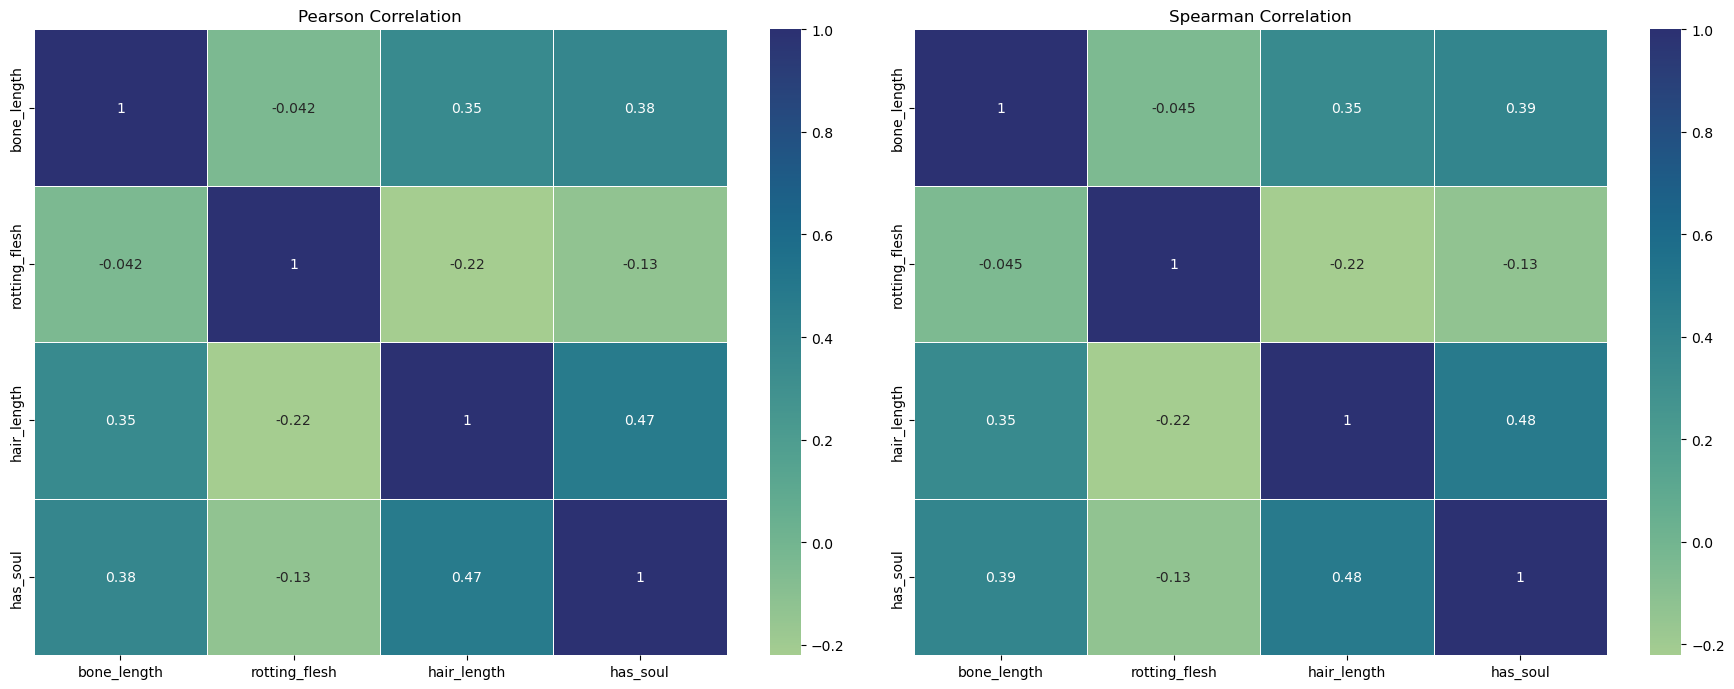

In [33]:
corr_pearson = boo_train.drop('id', axis=1).corr(numeric_only=True)
corr_spearman = boo_train.drop('id', axis=1).corr(method='spearman', numeric_only=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(corr_pearson, annot=True, cmap='crest', linewidths=0.5, ax=axes[0])
axes[0].set_title('Pearson Correlation')

sns.heatmap(corr_spearman, annot=True, cmap='crest', linewidths=0.5, ax=axes[1])
axes[1].set_title('Spearman Correlation')

plt.tight_layout()
plt.show();

Данные не коррелируют между собой. Можно использовать для дальнейшей работы. 

Посмотрим на сколько данные обучающей выборки (train.csv) сбалансированы.

In [34]:
type_distribution = boo_train["type"].value_counts(normalize=True).reset_index()
type_distribution.columns = ['type', 'fraction']
type_distribution['percentage'] = (type_distribution['fraction'] * 100).round(2)
type_distribution

,type,fraction,percentage
0,Ghoul,0.347709,34.77
1,Goblin,0.336927,33.69
2,Ghost,0.315364,31.54


Собранные данные по монстрам сбалансированы.

Дополнительно необходимо будет провести кодировку текстовых данных color - цвет монстров. 

## Подготовка данных к исследованию

Присвоем числовые значения для типов монстров Ghost = 0, Ghoul = 2, Goblin = 1

In [35]:
boo_train['boo'] = boo_train['type'].apply(lambda x: 0 if x == 'Ghost' else 2 if x == 'Ghoul' else 1)

Разделим тренировочную выборку на матрицу Х, содержащую признаки монстров и вектор Y, содержащий кодированное название монстров.

In [36]:
X = boo_train.drop(['id', 'type', 'boo'], axis = 1)
Y = boo_train['boo']

Подготовим тестовую выборку, для проверки на kaggle

In [37]:
X_t = boo_test.drop(['id'], axis = 1)

## Выбор модели для исследования

Мы имеем маленькую выборку, сбалансированные данные, небольшое количество признаков.

Попробуем основные модели, которые позволят провести классификацию разными методами: 
- Logistic Regression
- KNN (k-ближайших соседей)
- Decision Tree
- Naive Bayes
- SVM с линейным ядром
- RandomForest

Три варианта кодировки признака 'color':
- OneHotEncoder
- TargetEncoder
- LeaveOneOutEncoder

Для получения стабильного результата работы моделей будем использовать кросс валидацию k-fold. 

Для этого пропишем функцию, которая будет применять разные модели и применять три вида кодировки к текстовым параметрам и выдавать Accuracy, Precision, Recall, F1 Score. С сортировкой по F1 Score от большего к меньшему. Нас будут интересовать сочетание модели и способа кодировки с наибольшим F1 Score.

In [38]:
def algo_test_cv(X, y, cat_cols):
    encoders = {
        "LeaveOneOut": LeaveOneOutEncoder,
        "Target": TargetEncoder,
        "OneHot": OneHotEncoder
    }

    model_list = [
        (GaussianNB(), "GaussianNB"),
        (LogisticRegression(max_iter=1000), "LogisticRegression"),
        (DecisionTreeClassifier(), "DecisionTree"),
        (RandomForestClassifier(), "RandomForest"),
        (KNeighborsClassifier(), "KNN"),
        (SVC(), "SVM")
    ]

    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }

    results = []

    for enc_name, Encoder in encoders.items():
        for model, name in model_list:
            try:
                if enc_name == "OneHot":
                    ct = ColumnTransformer(
                        transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                        remainder='passthrough'
                    )
                    pipe = make_pipeline(ct, model)
                else:
                    encoder = Encoder(cols=cat_cols)
                    pipe = make_pipeline(encoder, model)

                scores = cross_validate(pipe, X, y, cv=5, scoring=scorers)

                results.append({
                    "Encoder": enc_name,
                    "Model": name,
                    "Accuracy": np.mean(scores['test_accuracy']),
                    "Precision": np.mean(scores['test_precision']),
                    "Recall": np.mean(scores['test_recall']),
                    "F1 Score": np.mean(scores['test_f1'])
                })
            except Exception as e:
                results.append({
                    "Encoder": enc_name,
                    "Model": name,
                    "Error": str(e)
                })

    return pd.DataFrame(results)

In [39]:
cat_cols = ['color']
algo_test_cv(X, Y, cat_cols)
df_rez = pd.DataFrame(algo_test_cv(X, Y, cat_cols))
df_rez.sort_values(['F1 Score'], ascending=False)

C:\Users\malen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\malen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Encoder,Model,Accuracy,Precision,Recall,F1 Score
11,Target,SVM,0.760108,0.766234,0.760108,0.759009
5,LeaveOneOut,SVM,0.754775,0.760974,0.754775,0.755356
1,LeaveOneOut,LogisticRegression,0.757441,0.757262,0.757441,0.751559
7,Target,LogisticRegression,0.754739,0.753277,0.754739,0.747319
6,Target,GaussianNB,0.727820,0.736438,0.727820,0.727490
0,LeaveOneOut,GaussianNB,0.725153,0.736480,0.725153,0.725161
10,Target,KNN,0.711495,0.722832,0.711495,0.713204
4,LeaveOneOut,KNN,0.706126,0.715298,0.706126,0.706864
13,OneHot,LogisticRegression,0.711532,0.710301,0.711532,0.702722
9,Target,RandomForest,0.695423,0.709026,0.695423,0.694852


Лучше всего показавывает модель SVM в сочетании с кодировкой TargetEncoder. 
Из кодировок хуже всего показал себя OneHotEncoder, не будем  его использовать для дальнейших проверок. 

Попробуем исследовать 5 моделей с лучшим результатом и разными кодировками. Для удобства будем использовать Pipeline. 

Pipeline будем строить по следующей схеме: 
 - 'cat_encoder' - применение кодировок TargetEncoder и LeaveOneOutEncoder,
 - 'poly_featurizer' - попробуем расширить наши данные данные с помощью обавив полиномиальные и взаимодействующие признаки,
 - 'gridsearch' -автоматический подбор оптимальных параметров,
 - 'selector' - и селектор для отбора только важных признаков
 - 'scaler' - будем использовать для масштабирования признаков совместно с poly_featurizer
 
 В зависимости от модели будем выбирать разную комбинацию.

#### Попробуем сравнить 18 вариантов с помощью Pipeline

In [40]:
pipe_svm_loo = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=2, include_bias=False)),
    ('gridsearch_', GridSearchCV(
        estimator=SVC(),
        param_grid={
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        },
        cv=5,
        scoring='f1_weighted'
    ))
])

pipe_svm_t = Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=2, include_bias=False)),
    ('gridsearch_', GridSearchCV(
        estimator=SVC(),
        param_grid={
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        },
        cv=5,
        scoring='f1_weighted'
    ))
])

pipe_svm_loo_1 = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('gridsearch_', GridSearchCV(
        estimator=SVC(),
        param_grid={
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        },
        cv=5,
        scoring='f1_weighted'
    ))
])

pipe_svm_t_1 = Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('gridsearch_', GridSearchCV(
        estimator=SVC(),
        param_grid={
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        },
        cv=5,
        scoring='f1_weighted'
    ))
])

pipe_logreg_loo = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=2, include_bias=False)),
    ('gridsearch_', GridSearchCV(
        estimator=LogisticRegression(solver='liblinear', max_iter=1000),
        param_grid={
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        },
        cv=5,
        scoring='f1_weighted'
    ))
])

pipe_logreg_t = Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=2, include_bias=False)),
    ('gridsearch_', GridSearchCV(
        estimator=LogisticRegression(solver='liblinear', max_iter=1000),
        param_grid={
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        },
        cv=5,
        scoring='f1_weighted'
    ))
])

pipe_logreg_loo_1 = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('gridsearch_', GridSearchCV(
        estimator=LogisticRegression(solver='liblinear', max_iter=1000),
        param_grid={
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        },
        cv=5,
        scoring='f1_weighted'
    ))
])

pipe_logreg_t_1 = Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('gridsearch_', GridSearchCV(
        estimator=LogisticRegression(solver='liblinear', max_iter=1000),
        param_grid={
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        },
        cv=5,
        scoring='f1_weighted'
    ))
])

pipe_rf_1 = Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4, include_bias=False)),
    ('gridsearch_', GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid={
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        },
        cv=5,
        n_jobs=-1,
        verbose=1
    ))
])

pipe_rf_2 = Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('gridsearch_', GridSearchCV(
        estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
        param_grid={
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        },
        cv=5,
        n_jobs=-1,
        verbose=1
    ))
])

pipe_gnb_loo = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                  threshold=1e-5)),
    ('gnb_', GaussianNB())
])

pipe_gnb_t = Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                  threshold=1e-5)),
    ('gnb_', GaussianNB())
])

pipe_gnb_loo_1 = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('gnb_', GaussianNB())
])

pipe_gnb_t_1 = Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('gnb_', GaussianNB())
])

pipe_knn_1 =  Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                  threshold=1e-5)),
    ('model_', KNeighborsClassifier())])

pipe_knn_2 =  Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                  threshold=1e-5)),
    ('model_', KNeighborsClassifier())])

pipe_knn_3 =  Pipeline([
    ('cat_encoder_', TargetEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('model_', KNeighborsClassifier())])

pipe_knn_4 =  Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('model_', KNeighborsClassifier())])

In [41]:
# Собираем все pipline вместе
pipeline_dict = {
    'pipe_svm_loo': pipe_svm_loo,
    'pipe_svm_t': pipe_svm_t,
    'pipe_svm_loo_1': pipe_svm_loo_1,
    'pipe_svm_t_1': pipe_svm_t_1,
    'pipe_logreg_loo': pipe_logreg_loo,
    'pipe_logreg_t': pipe_logreg_t,
    'pipe_logreg_loo_1': pipe_logreg_loo_1,
    'pipe_logreg_t_1': pipe_logreg_t_1,
    'pipe_rf_1': pipe_rf_1,
    'pipe_rf_2': pipe_rf_2,
    'pipe_gnb_loo': pipe_gnb_loo,
    'pipe_gnb_t': pipe_gnb_t,
    'pipe_gnb_loo_1': pipe_gnb_loo_1,
    'pipe_gnb_t_1': pipe_gnb_t_1,
    'pipe_knn_1': pipe_knn_1,
    'pipe_knn_2': pipe_knn_2,
    'pipe_knn_3': pipe_knn_3,
    'pipe_knn_4': pipe_knn_4,
}


results = []
# Собираем и обрабатываем результаты, но сортировать будем по разнице Accurancy и F1 Score
for name, pipe in pipeline_dict.items():
    cv_res = cross_validate(
        pipe,
        X,
        Y,
        cv=5,
        scoring={
            'accuracy': make_scorer(accuracy_score),
            'f1': make_scorer(f1_score, average='weighted')
        }
    )
    acc = cv_res['test_accuracy'].mean()
    f1 = cv_res['test_f1'].mean()
    diff = abs(f1 - acc)
    results.append({
        "Pipeline": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "|F1 - Accuracy|": diff
    })


df_results = pd.DataFrame(results).sort_values(by="|F1 - Accuracy|")


print(df_results.to_string(index=False))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
         Pipeline  Accuracy  F1 Score  |F1 - Accuracy|
   pipe_gnb_loo_1  0.725153  0.725161         0.000007
     pipe_gnb_t_1  0.727820  0.727490         0.000330
     pipe_svm_t_1  0.741189  0.740507         0.000682
       pipe_svm_t  0.743856  0.742945         0.000911
       pipe_knn_2  0.692505  0.693623         0.001118
   pipe_svm_loo_1  0.749261  0

## Проверка работы модели на Kaggle

 5 вариантов берем для окончательной проверки на сайте kaggle

Выбираем модели с наибольшим значением F1 Score и Accuracy и при этом минимальной разницей между двумя метриками. 

In [40]:
pipe_gnb_loo_1.fit(X, Y)

Pipeline(steps=[('cat_encoder_', LeaveOneOutEncoder(cols=['color'])),
                ('gnb_', GaussianNB())])

In [ ]:
y_pred = pipe_gnb_loo_1.predict(X_t)
df_pred = pd.DataFrame(y_pred, columns=["prediction"])
df_pred['id'] = boo_test['id']
df_pred['type'] = df_pred['prediction'].apply(lambda x: 'Ghost' if x == 0 else 'Ghoul' if x == 2 else 'Goblin')
df_pred = df_pred.drop('prediction', axis = 1)
df_pred.to_csv("gnb_loo.csv", index=False)

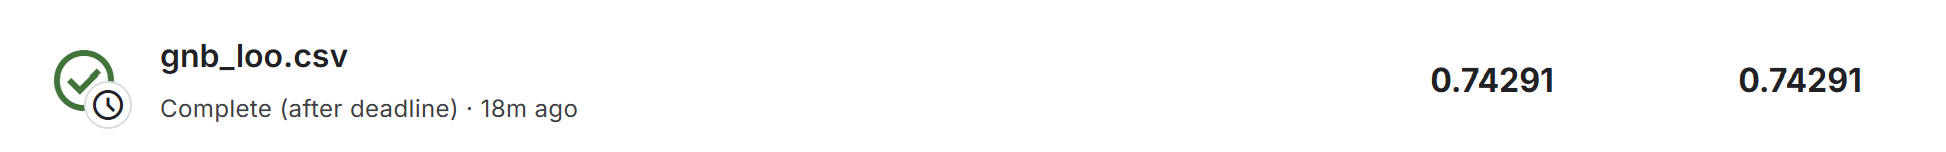

In [43]:
pipe_gnb_t_1.fit(X, Y)

Pipeline(steps=[('cat_encoder_', TargetEncoder(cols=['color'])),
                ('gnb_', GaussianNB())])

In [47]:
y_pred = pipe_gnb_t_1.predict(X_t)
df_pred = pd.DataFrame(y_pred, columns=["prediction"])
df_pred['id'] = boo_test['id']
df_pred['type'] = df_pred['prediction'].apply(lambda x: 'Ghost' if x == 0 else 'Ghoul' if x == 2 else 'Goblin')
df_pred = df_pred.drop('prediction', axis = 1)
df_pred.to_csv("gnb_t.csv", index=False)

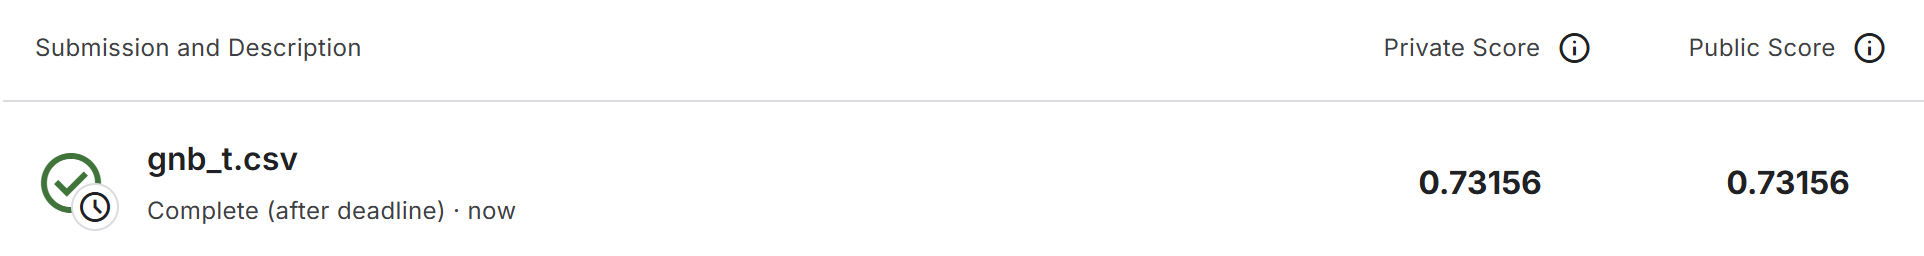

In [45]:
pipe_svm_t_1.fit(X, Y)

Pipeline(steps=[('cat_encoder_', TargetEncoder(cols=['color'])),
                ('gridsearch_',
                 GridSearchCV(cv=5, estimator=SVC(),
                              param_grid={'C': [0.1, 1, 10],
                                          'gamma': ['scale', 'auto'],
                                          'kernel': ['linear', 'rbf']},
                              scoring='f1_weighted'))])

In [46]:
y_pred = pipe_svm_t_1.predict(X_t)
df_pred = pd.DataFrame(y_pred, columns=["prediction"])
df_pred['id'] = boo_test['id']
df_pred['type'] = df_pred['prediction'].apply(lambda x: 'Ghost' if x == 0 else 'Ghoul' if x == 2 else 'Goblin')
df_pred = df_pred.drop('prediction', axis = 1)
df_pred.to_csv("svm_t_1.csv", index=False)
df_pred.head()

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghost
4,13,Ghost


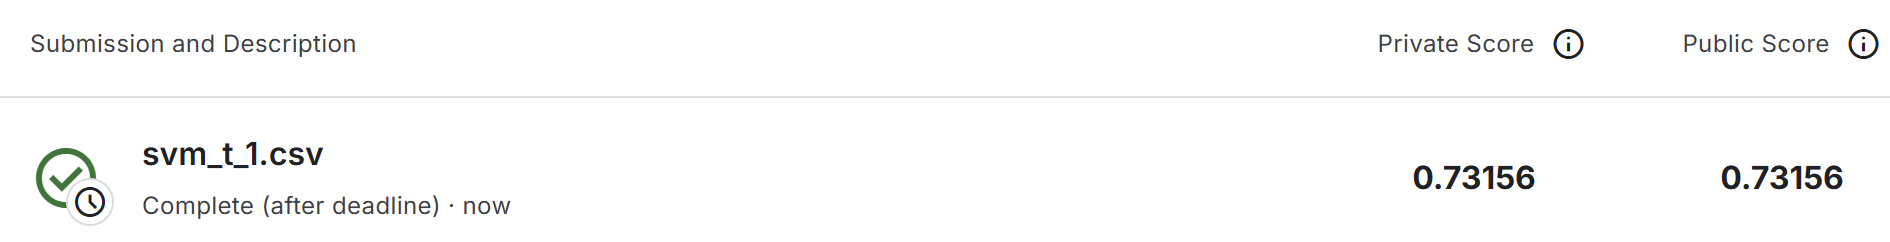

In [48]:
pipe_svm_t.fit(X, Y)

Pipeline(steps=[('cat_encoder_', TargetEncoder(cols=['color'])),
                ('poly_featurizer_', PolynomialFeatures(include_bias=False)),
                ('gridsearch_',
                 GridSearchCV(cv=5, estimator=SVC(),
                              param_grid={'C': [0.1, 1, 10],
                                          'gamma': ['scale', 'auto'],
                                          'kernel': ['linear', 'rbf']},
                              scoring='f1_weighted'))])

In [49]:
y_pred = pipe_svm_t.predict(X_t)
df_pred = pd.DataFrame(y_pred, columns=["prediction"])
df_pred['id'] = boo_test['id']
df_pred['type'] = df_pred['prediction'].apply(lambda x: 'Ghost' if x == 0 else 'Ghoul' if x == 2 else 'Goblin')
df_pred = df_pred.drop('prediction', axis = 1)
df_pred.to_csv("svm_t.csv", index=False)

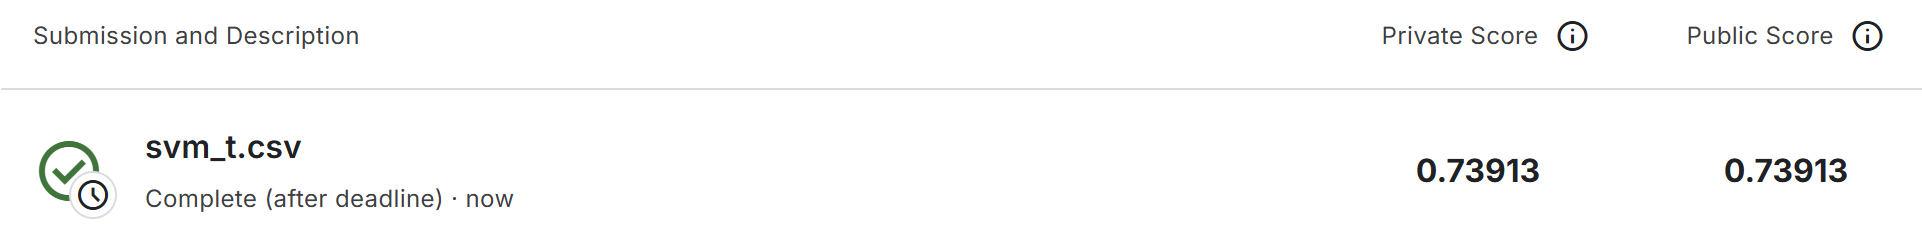

In [34]:
pipe_svm_loo_1.fit(X, Y)

Pipeline(steps=[('cat_encoder_', LeaveOneOutEncoder(cols=['color'])),
                ('gridsearch_',
                 GridSearchCV(cv=5, estimator=SVC(),
                              param_grid={'C': [0.1, 1, 10],
                                          'gamma': ['scale', 'auto'],
                                          'kernel': ['linear', 'rbf']},
                              scoring='f1_weighted'))])

In [50]:
y_pred = pipe_svm_loo_1.predict(X_t)
df_pred = pd.DataFrame(y_pred, columns=["prediction"])
df_pred['id'] = boo_test['id']
df_pred['type'] = df_pred['prediction'].apply(lambda x: 'Ghost' if x == 0 else 'Ghoul' if x == 2 else 'Goblin')
df_pred = df_pred.drop('prediction', axis = 1)
df_pred.to_csv("svm_loo_1.csv", index=False)

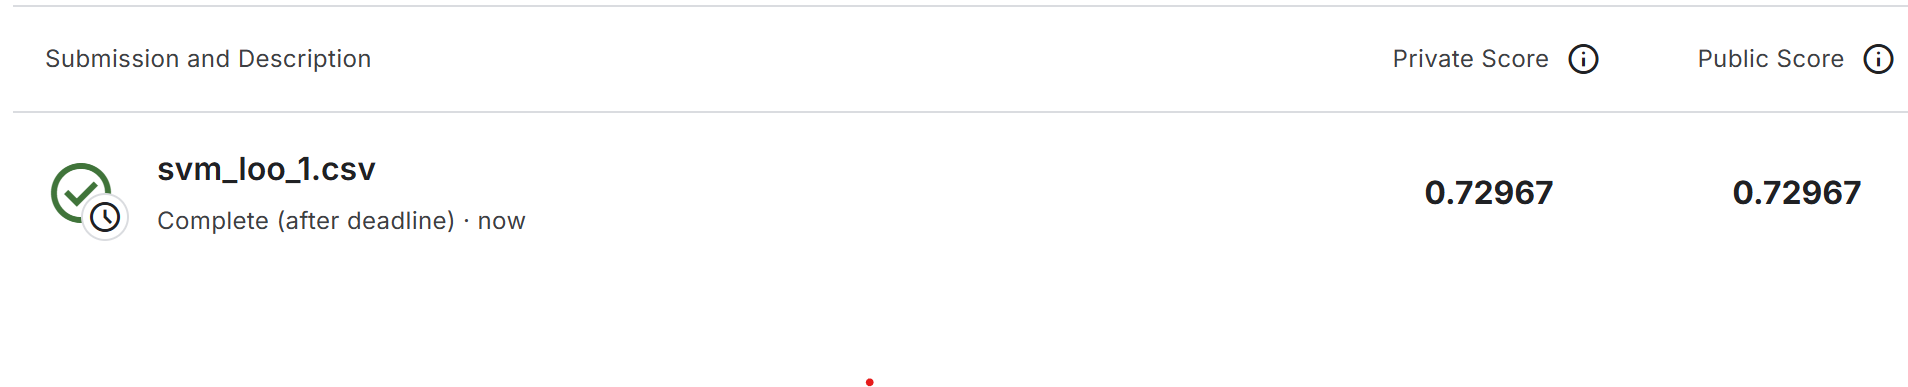

## Итоги:

В рамках проекта была решена задача многоклассовой классификации для Kaggle-соревнования [Ghouls, Goblins, and Ghosts... Boo!](https://www.kaggle.com/competitions/ghouls-goblins-and-ghosts-boo/overview).

### Что сделано:
- Проведен первичный анализ и предобработка признаков (`EDA`).
- Протестированы различные методы кодирования категориальных признаков:
  - One-Hot Encoding
  - Target Encoding
  - Leave-One-Out Encoding
- Построены и обучены модели:
  - Logistic Regression
  - K-Nearest Neighbors
  - Decision Tree
  - Random Forest
  - Naive Bayes
  - SVM
- Использовались пайплайны и GridSearchCV для настройки параметров.

### Лучшие результаты:
- Модель **GaussianNB** показала наивысшую точность классификации:  **F1 = 0.743**
- Лучшая схема кодирования признаков: **LeaveOneOutEncoder**
- Модель демонстрирует стабильные результаты на кросс-валидации.